✅ Parsed portfolio weights:

SGOV = 38.38%
ULTY = 15.87%
RDDT = 14.69%
GOOGL = 9.79%
META = 9.05%
ASTS = 7.34%
QQQM = 4.87%
INTU = 0.00%
BRK/B = 0.00%
HOOD = 0.00%
NBIS = 0.00%
SHOP = 0.00%
SNOW = 0.00%
TQQQ = 0.00%

✅ Total portfolio weight: 100.00%

Realized Risk Metrics (5 years)

Annualized Return      : 17.48%
Annualized Volatility  : 21.71%
Sharpe Ratio (rf=5%)   : 0.57
Max Drawdown           : -33.01%
1-Day VaR  (95%): -2.04% (~$-2,037)
1-Day CVaR (95%): -2.97% (~$-2,968)
Skewness               : -0.81
Kurtosis               : 14.71
Beta vs. S&P 500       : 0.90
Beta vs. Nasdaq-100    : 0.72

❤️ DAISY ❤️

Correlation Matrix (5 years):

       ASTS  GOOGL  META  QQQM  RDDT  SGOV  ULTY
ASTS   1.00   0.21  0.20  0.21  0.19 -0.01  0.17
GOOGL  0.21   1.00  0.60  0.50  0.55  0.02  0.33
META   0.20   0.60  1.00  0.47  0.46  0.02  0.31
QQQM   0.21   0.50  0.47  1.00  0.37  0.02  0.30
RDDT   0.19   0.55  0.46  0.37  1.00  0.00  0.28
SGOV  -0.01   0.02  0.02  0.02  0.00  1.00 -0.03
ULTY  

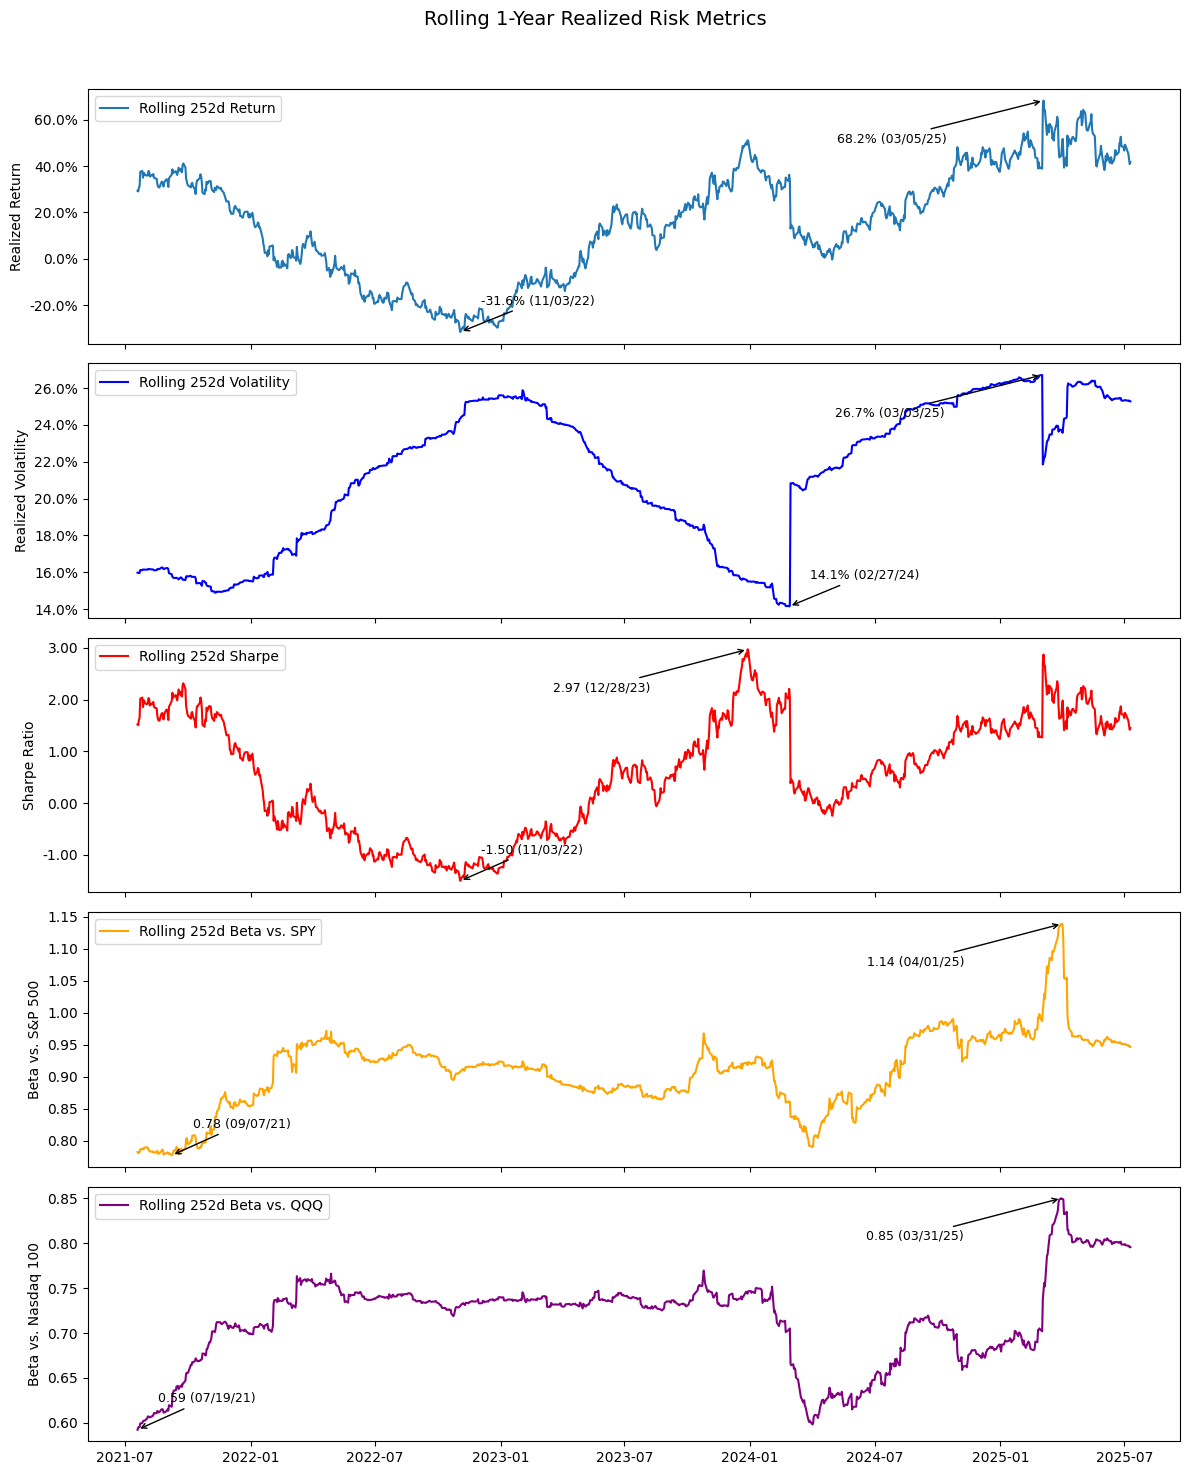


✅ Wrote: csv_export\Returns.csv
✅ Wrote: csv_export\HOOD.csv
✅ Wrote: csv_export\NBIS.csv
✅ Wrote: csv_export\RDDT.csv
✅ Wrote: csv_export\SHOP.csv
✅ Wrote: csv_export\SNOW.csv

📁 All exports saved in: C:\Users\ahv25\Desktop\Python\notebooks\csv_export


In [43]:
"""Daisy's Realizd Risk Metrics
======================================

Key parameters
--------------
YEARS, CONF_LVL, PORTF_VALUE_USD, WEIGHTS, PROXY.

Guarantees
----------
• Any funded ticker missing data aborts.  
• Only pre‑IPO gaps filled (no smoothing halts).  
• Final dashboard prints one metric per line.
"""

from __future__ import annotations
import pandas as pd, numpy as np, yfinance as yf
import logging, contextlib, io, os, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# ────────── 1) USER SETTINGS ──────────
YEARS           = 5
CONF_LVL        = 0.95
PORTF_VALUE_USD = 100_000
RISK_FREE_RATE  = .05
ROLLING_WINDOW = 252

CSV_PATH = os.path.join("..", "data", "portfolio_weights.csv")
PROXY_CSV_PATH = os.path.join("..", "data", "proxy_mapping.csv")

if not os.path.isfile(CSV_PATH):
    print(f"❌ Portfolio file not found: {CSV_PATH}")
    print("Aborting. Please make sure the portfolio_weights.csv file exists in the /data folder.")
    raise SystemExit

df = pd.read_csv(CSV_PATH, dtype={"Ticker": str, "Weight": float})

# Clean and sort
df["Ticker"] = df["Ticker"].str.strip()
df = df.groupby("Ticker", as_index=False)["Weight"].sum()

# Print and validate
total_weight = df["Weight"].sum()
print("✅ Parsed portfolio weights:\n")
for _, row in df.sort_values("Weight", ascending=False).iterrows():
    print(f"{row['Ticker']} = {row['Weight'] * 100:.2f}%")

print(f"\n✅ Total portfolio weight: {total_weight * 100:.2f}%\n")

# Construct weights dictionary
WEIGHTS = dict(zip(df["Ticker"], df["Weight"]))

BENCH_SPY, BENCH_QQQ = "SPY", "QQQ"

# Load proxy mapping CSV
# Check if file exists
if not os.path.isfile(PROXY_CSV_PATH):
    raise FileNotFoundError(f"Proxy file not found: {PROXY_CSV_PATH}")

# Read the CSV
proxy_df = pd.read_csv(PROXY_CSV_PATH)

# Construct the PROXY dictionary
PROXY = {}
for target, group in proxy_df.groupby("Target"):
    PROXY[target] = list(zip(group["Proxy"], group["Weight"]))

# ────────── 2) HELPERS ──────────
logging.getLogger("yfinance").setLevel(logging.CRITICAL)
TRADING_DAYS_YR = 252

@contextlib.contextmanager
def silence():
    with contextlib.redirect_stdout(io.StringIO()):
        yield

def adj_close(df: pd.DataFrame, t: str) -> pd.Series:
    close = df.xs("Close", level=0, axis=1).squeeze("columns") if isinstance(df.columns, pd.MultiIndex) else df["Close"]
    close.name = t
    return close

# ────────── 3) DOWNLOAD PRICES ──────────
window = int(YEARS * TRADING_DAYS_YR)
start  = pd.Timestamp.today().normalize() - pd.tseries.offsets.BDay(window + 40)
end    = pd.Timestamp.today().normalize()

proxy_members = {m for v in PROXY.values() for m in ([v] if isinstance(v, str) else [x for x, _ in v])}
universe = set(WEIGHTS) | {BENCH_SPY, BENCH_QQQ} | proxy_members

prices: dict[str, pd.Series] = {}
for tic in universe:
    with silence():
        raw = yf.download(tic, start=start, end=end, auto_adjust=True, progress=False, threads=False)
    if raw.empty:
        if WEIGHTS.get(tic, 0) > 0:
            raise RuntimeError(f"Missing data for funded ticker {tic}")
        continue
    prices[tic] = adj_close(raw, tic)

if BENCH_QQQ not in prices:
    raise RuntimeError("QQQ data missing")

df = pd.concat(prices.values(), axis=1)
qqq_series = df[BENCH_QQQ].ffill()

# ────────── 4) PROXY FILL ──────────

def proxy_ser(spec):
    return df.get(spec, qqq_series) if isinstance(spec, str) else pd.concat([df.get(t, qqq_series)*w for t, w in spec], axis=1).sum(axis=1)

filled = []
for tic, w in WEIGHTS.items():
    base = df.get(tic, pd.Series(index=df.index, dtype=float, name=tic))
    prox = proxy_ser(PROXY.get(tic, BENCH_QQQ))
    first = base.first_valid_index()
    combined = prox if first is None else base.combine_first(prox.where((base.index < first) & base.isna()))
    filled.append(combined)

filled.extend([df[BENCH_SPY], df[BENCH_QQQ]])
prices_clean = pd.concat(filled, axis=1)
prices_clean = prices_clean.loc[:, ~prices_clean.columns.duplicated()]  # dedupe
prices_clean = prices_clean.dropna().tail(window + 1)

# ────────── 5) RETURNS ──────────
rets = prices_clean.pct_change().dropna()
active_weights = {t: w for t, w in WEIGHTS.items() if t in rets.columns and w > 0}
portfolio_r = rets[list(active_weights)] @ pd.Series(active_weights)
spy_r = rets[BENCH_SPY]
qqq_r = rets[BENCH_QQQ]

# ────────── 6) METRICS ──────────
ann_ret = (1+portfolio_r).prod()**(TRADING_DAYS_YR/len(portfolio_r))-1
ann_vol = portfolio_r.std(ddof=0)*np.sqrt(TRADING_DAYS_YR)
sharpe  = np.nan if ann_vol==0 else (ann_ret-RISK_FREE_RATE)/ann_vol
cum = (1+portfolio_r).cumprod()
max_dd = (cum/cum.cummax()-1).min()
alpha = 1-CONF_LVL
var_pct = np.percentile(portfolio_r, alpha*100)
cvar_pct = portfolio_r[portfolio_r<=var_pct].mean()
beta_spy = portfolio_r.cov(spy_r)/spy_r.var()
beta_qqq = portfolio_r.cov(qqq_r)/qqq_r.var()
skewness = portfolio_r.skew()
kurtosis = portfolio_r.kurtosis()

# ────────── 7) RISK METRICS SUMMARY ──────────
level = int(CONF_LVL*100)

print("\n".join([
    f"Realized Risk Metrics ({YEARS} years)\n",
    f"Annualized Return      : {ann_ret:.2%}",
    f"Annualized Volatility  : {ann_vol:.2%}",
    f"Sharpe Ratio (rf={RISK_FREE_RATE:.0%})   : {sharpe:.2f}",
    f"Max Drawdown           : {max_dd:.2%}",
    f"1-Day VaR  ({level}%): {var_pct:.2%} (~${var_pct*PORTF_VALUE_USD:,.0f})",
    f"1-Day CVaR ({level}%): {cvar_pct:.2%} (~${cvar_pct*PORTF_VALUE_USD:,.0f})",
    f"Skewness               : {skewness:.2f}",
    f"Kurtosis               : {kurtosis:.2f}",
    f"Beta vs. S&P 500       : {beta_spy:.2f}",
    f"Beta vs. Nasdaq-100    : {beta_qqq:.2f}",
    f"\n❤️ DAISY ❤️\n"
]))

print(f"Correlation Matrix ({YEARS} years):\n")
print(rets[list(active_weights)].corr().round(2).to_string())

# ────────── 8) ROLLING RISK METRICS ──────────

# --- Use actual portfolio returns for rolling metrics ---
portfolio_r = portfolio_r.copy()
spy_r = spy_r.copy()
qqq_r = qqq_r.copy()

# --- Rolling Metrics ---
rolling_return = (1 + portfolio_r).rolling(ROLLING_WINDOW).apply(np.prod, raw=True)**(252/ROLLING_WINDOW) - 1
rolling_vol = portfolio_r.rolling(ROLLING_WINDOW).std(ddof=0) * np.sqrt(252)
rolling_sharpe = (rolling_return - RISK_FREE_RATE) / rolling_vol
rolling_beta_spy = portfolio_r.rolling(ROLLING_WINDOW).cov(spy_r) / spy_r.rolling(ROLLING_WINDOW).var()
rolling_beta_qqq = portfolio_r.rolling(ROLLING_WINDOW).cov(qqq_r) / qqq_r.rolling(ROLLING_WINDOW).var()

# --- Annotator ---
def annotate_high_low(ax, series, format_fn, y_offset=0.05):
    low_idx, high_idx = series.idxmin(), series.idxmax()
    low_val, high_val = series[low_idx], series[high_idx]

    # Offsets dynamically: low → up-right, high → down-left
    ax.annotate(f"{format_fn(low_val)} ({low_idx:%m/%d/%y})",
                xy=(low_idx, low_val),
                xytext=(15, 20), textcoords='offset points',
                ha='left', fontsize=9,
                arrowprops=dict(arrowstyle='->'))

    ax.annotate(f"{format_fn(high_val)} ({high_idx:%m/%d/%y})",
                xy=(high_idx, high_val),
                xytext=(-70, -30), textcoords='offset points',
                ha='right', fontsize=9,
                arrowprops=dict(arrowstyle='->'))

# --- Plotting ---
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)
print()

# 1. Return
axes[0].plot(rolling_return)
axes[0].set_ylabel("Realized Return")
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.1f}%"))
axes[0].legend(["Rolling 252d Return"])
annotate_high_low(axes[0], rolling_return, lambda y: f"{y*100:.1f}%")

# 2. Volatility
axes[1].plot(rolling_vol, color='blue')
axes[1].set_ylabel("Realized Volatility")
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.1f}%"))
axes[1].legend(["Rolling 252d Volatility"])
annotate_high_low(axes[1], rolling_vol, lambda y: f"{y*100:.1f}%")

# 3. Sharpe
axes[2].plot(rolling_sharpe, color='red')
axes[2].set_ylabel("Sharpe Ratio")
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))
axes[2].legend(["Rolling 252d Sharpe"])
annotate_high_low(axes[2], rolling_sharpe, lambda y: f"{y:.2f}")

# 4. Beta vs SPY
axes[3].plot(rolling_beta_spy, color='orange')
axes[3].set_ylabel("Beta vs. S&P 500")
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))
axes[3].legend(["Rolling 252d Beta vs. SPY"])
annotate_high_low(axes[3], rolling_beta_spy, lambda y: f"{y:.2f}")

# 5. Beta vs QQQ
axes[4].plot(rolling_beta_qqq, color='purple')
axes[4].set_ylabel("Beta vs. Nasdaq 100")
axes[4].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))
axes[4].legend(["Rolling 252d Beta vs. QQQ"])
annotate_high_low(axes[4], rolling_beta_qqq, lambda y: f"{y:.2f}")

# Layout
plt.suptitle("Rolling 1-Year Realized Risk Metrics", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print()

# ────────── 9) EXPORT RETURNS TO CSV ──────────

# 1️⃣ Output folder
output_dir = Path("csv_export")
output_dir.mkdir(exist_ok=True)

# 2️⃣ Main "Returns.csv": portfolio tickers, proxy-adjusted
returns_all = pd.concat(filled, axis=1)
returns_all = returns_all.loc[:, ~returns_all.columns.duplicated()]  # Remove duplicated tickers (e.g. QQQ)
returns_all = returns_all.dropna().pct_change().dropna()
returns_all.index.name = "Date"
returns_all.to_csv(output_dir / "Returns.csv")
print(f"✅ Wrote: {output_dir/'Returns.csv'}")

# 3️⃣ Per-proxy raw constituent return files
for target, spec in PROXY.items():
    if isinstance(spec, str):
        if spec in df.columns:  # <- fix here
            returns_proxy = df[[spec]].pct_change().dropna()
            returns_proxy.index.name = "Date"
            returns_proxy.to_csv(output_dir / f"{target}.csv")
            print(f"✅ Wrote: {output_dir / f'{target}.csv'}")
    else:
        tickers = [t for t, _ in spec if t in df.columns]
        if tickers:
            returns_proxy = df[tickers].pct_change().dropna()
            returns_proxy.index.name = "Date"
            returns_proxy.to_csv(output_dir / f"{target}.csv")
            print(f"✅ Wrote: {output_dir / f'{target}.csv'}")

print(f"\n📁 All exports saved in: {output_dir.resolve()}")
